# CBTN learning lab for multi-modal imaging
## Tumor size assessment over time using volumetric segmentations
#### October 10, 2024

This notebook illustrates how to extract tumor volumetrics to assess changes in tumor size over time. Assuming 3D volumetric segmentations have been generated such as via the `d3b-ped-auto-seg-nnunet` or `brats2024-peds-awssme` deep learning-based segmentation gears, and if necessary manually edited for accuracy.

In [ ]:
import flywheel
import os

your_api_key = 'enter-your-api-key'
fw = flywheel.Client(your_api_key)

In [62]:

fw = flywheel.Client(os.getenv('FW_LAB_API_KEY'))

In [150]:
# get the project container
proj_container = fw.lookup('cbtn-summit/CBTN_proc_data')

# set up a local folder to store the data files in
def maybe_make_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

local_data_dir = 'data'
maybe_make_dir(local_data_dir)

# loop through all files in the project
# if an edited tumor seg file exists then download it to the local folder
for session in proj_container.sessions.iter():
    sub_label = session.subject.label
    ses_label = session.label
    for acquisition in session.acquisitions.iter():
        for file_ in acquisition.files:
            if ('ManualSegmentation' in file_.name):
                local_session_dir = f'{local_data_dir}/{sub_label}/{ses_label}/'
                maybe_make_dir(local_session_dir)
                local_file_path = f'{local_session_dir}/{file_.name}'
                if not os.path.exists(local_file_path):
                    acquisition.download_file(file_.name, local_file_path)


In [151]:
import nibabel as nib
import numpy as np

# initialize volume calculator
def calculate_whole_tumor_size(seg_filename):
    mask = nib.load(seg_filename).get_fdata()
    mask = np.rint(mask)

    seg_voxels = mask[mask!=0]
    return len(seg_voxels)


In [152]:
from glob import glob
import pandas as pd

file_list = glob(f'{local_data_dir}/*/*/*.nii.gz')

# initialize our results lists
results = []

for seg_file_path in file_list:
    sub_label = seg_file_path.split('/')[1]
    ses_label = seg_file_path.split('/')[2]
    size_in_vox = calculate_whole_tumor_size(seg_file_path)
    results.append([sub_label, ses_label, size_in_vox])

# convert our list into a pandas dataframe
df = pd.DataFrame(results, columns=['subject','session','tumor_size_vox'])



In [153]:
df.head()

,subject,session,tumor_size_vox
0,C2479803,6046,11591
1,C2479803,6681,4065
2,C2479803,6229,164
3,C2479803,6611,2933
4,C2479803,6322,4146


In [154]:
df['session'] = df['session'].astype(int)
df = df.sort_values(by='session', axis=0).reset_index(drop=True)


In [155]:
df.head()

,subject,session,tumor_size_vox
0,C1173420,697,1869
1,C1173420,791,3333
2,C1277724,4762,31416
3,C1277724,4921,2791
4,C1277724,5005,7890


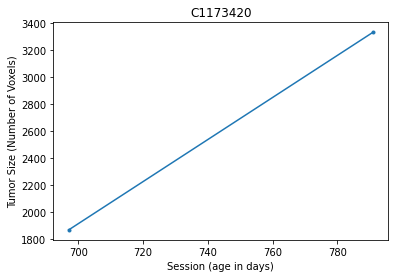

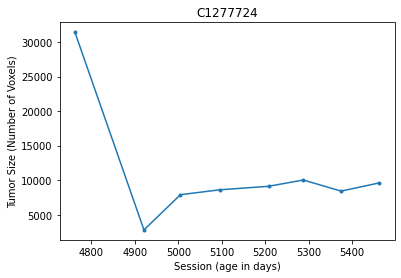

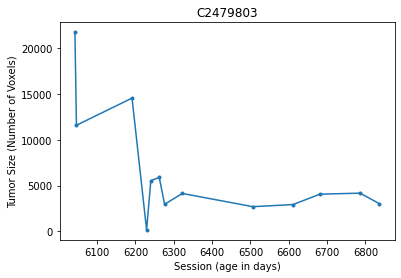

In [156]:
import matplotlib.pyplot as plt

# for each unique subject, plot their tumor volume over time
for sub in df['subject'].unique().tolist():
    sub_df = df[df['subject']==sub]
    plt.plot(sub_df['session'], sub_df['tumor_size_vox'],'.-')
    plt.xlabel('Session (age in days)')
    plt.ylabel('Tumor Size (Number of Voxels)')
    plt.title(sub)
    plt.show()



In [157]:

def calculate_region_tumor_size(seg_filename, n_values):
    mask = nib.load(seg_filename).get_fdata()
    mask = np.rint(mask)
    
    results = []
    for vox_value in range(1, n_values+1):
        seg_voxels = mask[mask==vox_value]
        region_size = len(seg_voxels)
        results.append(region_size)
    
    return results


In [158]:
# initialize our results lists
results = []

for seg_file_path in file_list:
    sub_label = seg_file_path.split('/')[1]
    ses_label = seg_file_path.split('/')[2]
    region_sizes = calculate_region_tumor_size(seg_file_path, 4)
    results.append([sub_label, ses_label] + region_sizes)

# convert our list into a pandas dataframe
region_df = pd.DataFrame(results, columns=['subject','session',\
                                    'enhancing',\
                                    'non-enhancing',\
                                    'cyst',\
                                    'edema'])



# enhancing_mask = np.logical_and(mask >= 1, mask <= 1)
# nonenhancing_mask = np.logical_and(mask >= 2, mask <= 2)
# cyst_mask = np.logical_and(mask >= 3, mask <= 3)
# edema_mask = np.logical_and(mask >= 4, mask <= 4)
# wt_mask = np.logical_and(mask >= 1, mask <= 3)

In [159]:
region_df['session'] = region_df['session'].astype(int)
region_df = region_df.sort_values(by='session', axis=0).reset_index(drop=True)


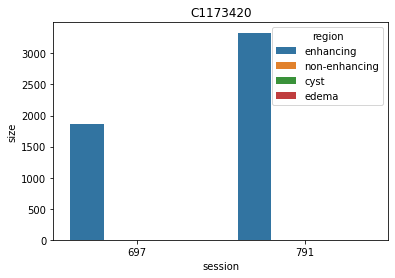

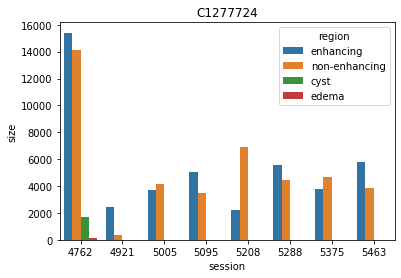

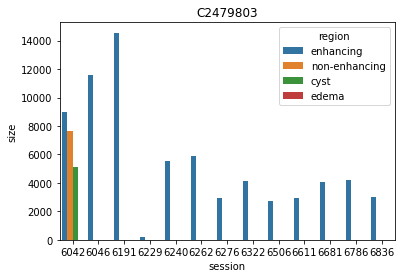

In [160]:
import seaborn as sns

region_labels = ['enhancing','non-enhancing','cyst','edema']
for sub in region_df['subject'].unique().tolist():
    sub_df = region_df[region_df['subject']==sub]
    size_values = []
    region_values=[]
    for region in region_labels:
        sizes_this_region = sub_df[region].tolist()
        size_values = size_values + sizes_this_region
        region_values = region_values + ([region] * len(sizes_this_region))
    plot_df = pd.DataFrame()
    plot_df['size'] = size_values
    plot_df['region'] = region_values
    plot_df['session'] = sub_df['session'].tolist() * int(len(plot_df) / len(sub_df['session'].tolist()))
    plt.figure()
    sns.barplot(plot_df, x="session", y="size", hue="region")
    plt.title(sub)
    plt.show()
